In [1]:
# system
import warnings
import os

# operation
import pandas as pd
import numpy as np
import pickle

# visulization
import matplotlib.pyplot as plt
import seaborn as sns

# feature engineering
#from statsmodels.stats.outliers_influence import variance_inflation_factor
# from scipy.stats import chi2_contingency, f_oneway
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder

# modeling
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, precision_recall_fscore_support

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
%config InlineBackend.figure_format = 'retina'

In [2]:
init_df = pd.read_csv('../dataset/train.csv')
df = init_df.copy()

print('Columns Name:',df.columns.to_list())
print("Total Columns:",sum(df.columns.value_counts()))
print("Total Rows:",df.shape[0])

Columns Name: ['id', 'Gender', 'Age', 'Driving_License', 'Region_Code', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage', 'Response']
Total Columns: 12
Total Rows: 381109


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  object 
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  int64  
 4   Region_Code           381109 non-null  float64
 5   Previously_Insured    381109 non-null  int64  
 6   Vehicle_Age           381109 non-null  object 
 7   Vehicle_Damage        381109 non-null  object 
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  float64
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


In [4]:
print(df.duplicated().sum())
df.describe()

0


id            Age  Driving_License    Region_Code  \
count  381109.000000  381109.000000    381109.000000  381109.000000   
mean   190555.000000      38.822584         0.997869      26.388807   
std    110016.836208      15.511611         0.046110      13.229888   
min         1.000000      20.000000         0.000000       0.000000   
25%     95278.000000      25.000000         1.000000      15.000000   
50%    190555.000000      36.000000         1.000000      28.000000   
75%    285832.000000      49.000000         1.000000      35.000000   
max    381109.000000      85.000000         1.000000      52.000000   

       Previously_Insured  Annual_Premium  Policy_Sales_Channel  \
count       381109.000000   381109.000000         381109.000000   
mean             0.458210    30564.389581            112.034295   
std              0.498251    17213.155057             54.203995   
min              0.000000     2630.000000              1.000000   
25%              0.000000    24405.000000             29.000000   
50%              0.000000    31669.000000            133.000000   
75%              1.000000    39400.000000            152.000000   
max              1.000000   540165.000000            163.000000   

             Vintage       Response  
count  381109.000000  381109.000000  
mean      154.347397       0.122563  
std        83.671304       0.327936  
min        10.000000       0.000000  
25%        82.000000       0.000000  
50%       154.000000       0.000000  
75%       227.000000       0.000000  
max       299.000000       1.000000

## Analysing Health Insurance Premium

All the categorical variables are legit, no data integrity issue with categorical features. However, there seems to be a requirement for outlier treatment in annual health premiums.

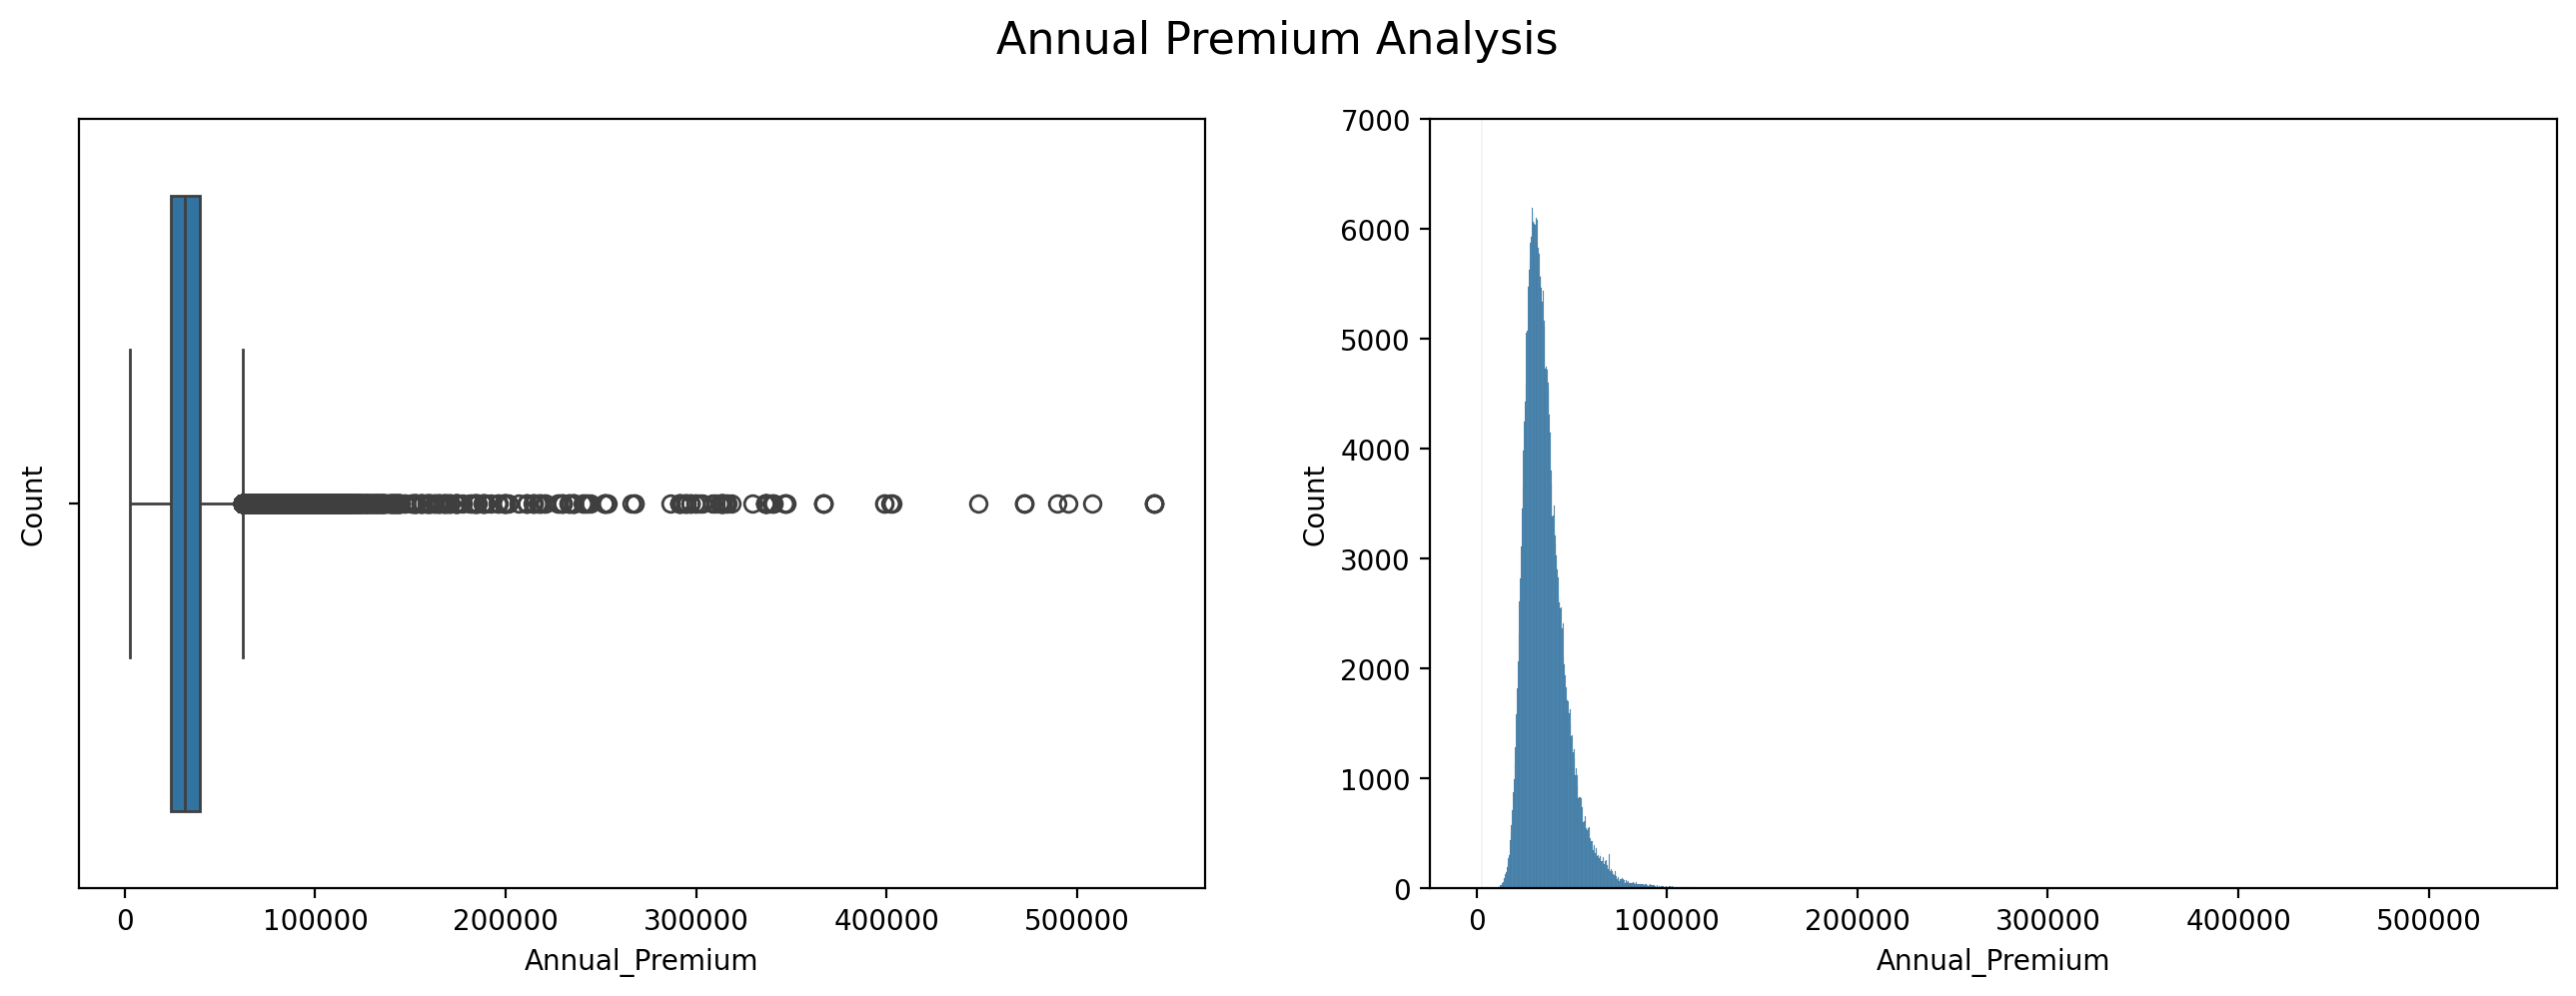

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))
fig.suptitle('Annual Premium Analysis', fontsize=16)

sns.boxplot(data=df, x='Annual_Premium', ax=ax[0])
ax[0].set_ylabel('Count')

sns.histplot(data=df, x='Annual_Premium', ax=ax[1])
ax[1].set_ylim(0, 7000)

plt.show()

Identifying extreme bounds of insurance premium

In [6]:
# using iqr as the data is right skewed
Q1 = df['Annual_Premium'].quantile(0.25)
Q3 = df['Annual_Premium'].quantile(0.75)
IQR = Q3 - Q1
print(f'extreme bound as per iqr analysis: {Q3-1.5*IQR}, {Q3+1.5*IQR}')

extreme bound as per iqr analysis: 16907.5, 61892.5


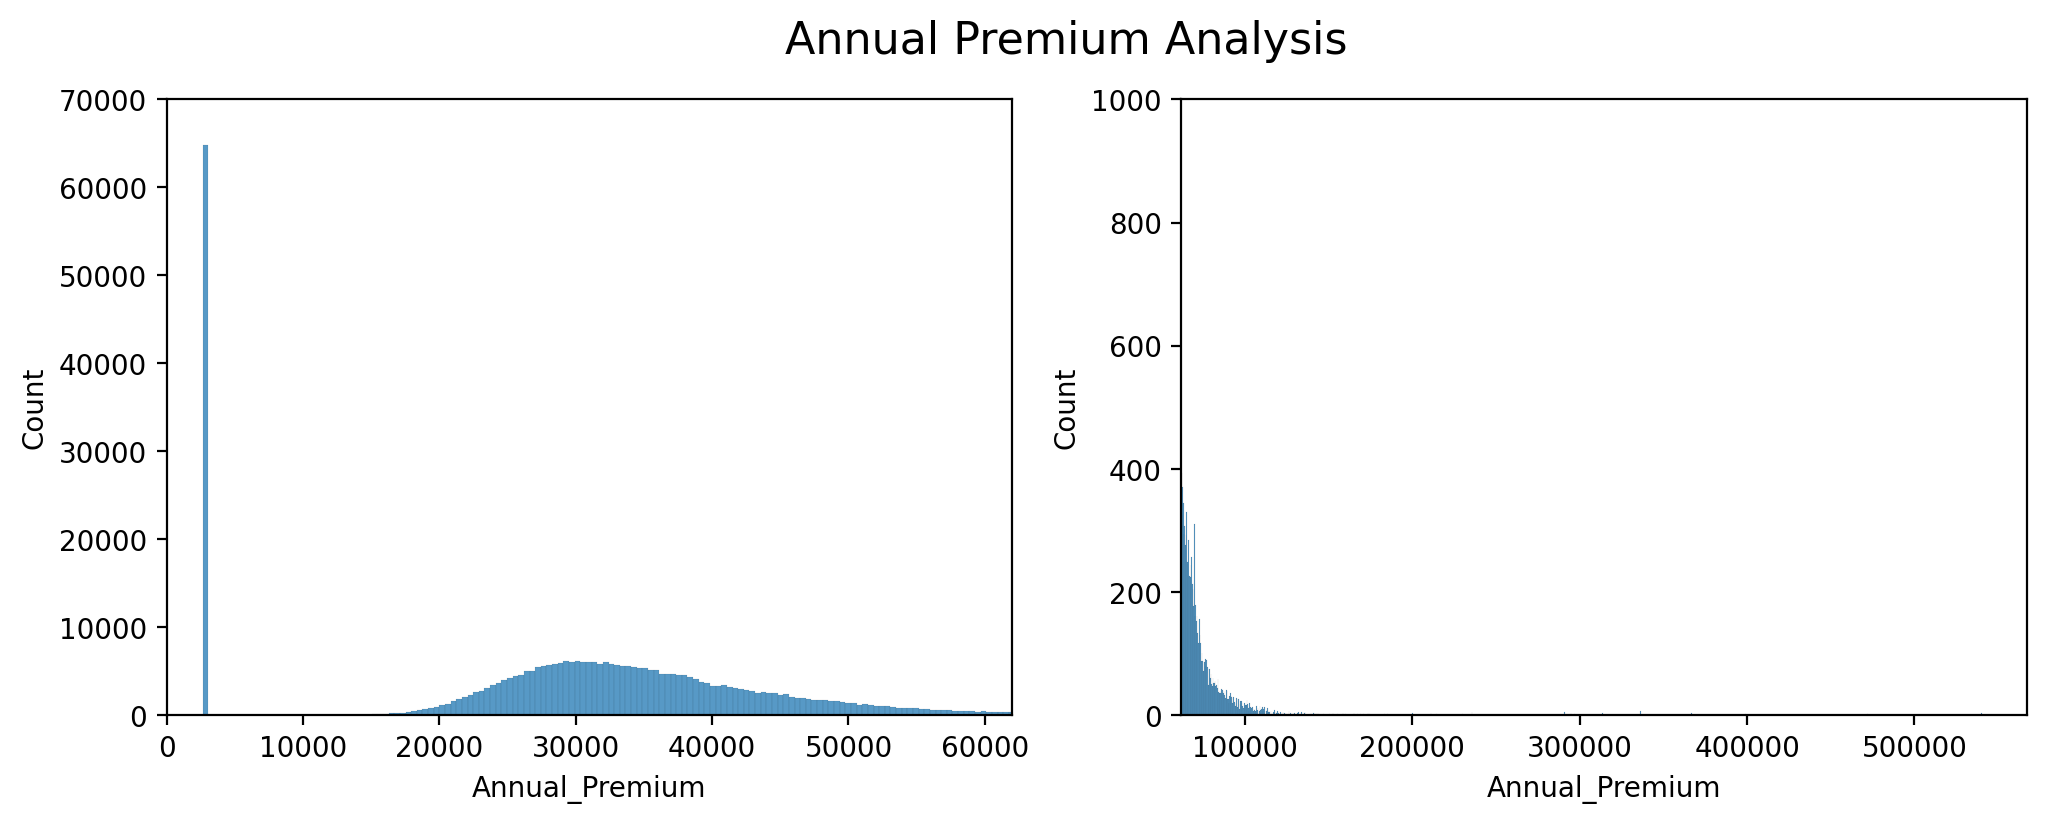

In [7]:
# basis of previous plot and upper bounds, the x limits are determined
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

sns.histplot(data=df, x='Annual_Premium', ax=ax[0])
ax[0].set_xlim(0, 62000)
ax[0].set_ylim(0, 70000)

sns.histplot(data=df, x='Annual_Premium', ax=ax[1])
ax[1].set_xlim(62000, )
ax[1].set_ylim(0, 1000)

fig.suptitle('Annual Premium Analysis', fontsize=16);

- There is a significant spike/bar around low value (2000-3000), indicating that a large number of customers have low annual premium. This could be due to various reasons such as data entry errors, promotional offers, or specific policies with no annual premium.
- Excluding the spike/bar, the distribution of the annual premium appears to be right-skewed.

Review data excluding the spikes, appears anomalie.

In [8]:
df[df['Annual_Premium'] < 10000]['Annual_Premium'].value_counts()

Annual_Premium
2630.0    64877
9816.0        1
6098.0        1
7670.0        1
9792.0        1
8739.0        1
Name: count, dtype: int64

In [9]:
df1 = df.query('Annual_Premium == 2630')
df2 = df.query('Annual_Premium > 2630')

In [10]:
anomaly_count = df[df['Annual_Premium'] == 2630]['Annual_Premium'].count()
anomaly_pct = 100*anomaly_count/df.shape[0]
good_record = df.shape[0]*(1-anomaly_pct/100)
print('total insurance in record: ', df.shape[0])
print(f"percent of insurance with very low annual premium is {anomaly_pct: .2f}")
print("if anomalies removed, we will have {:.0f} good records in the dataset.".format(good_record))

total insurance in record:  381109
percent of insurance with very low annual premium is  17.02
if anomalies removed, we will have 316232 good records in the dataset.


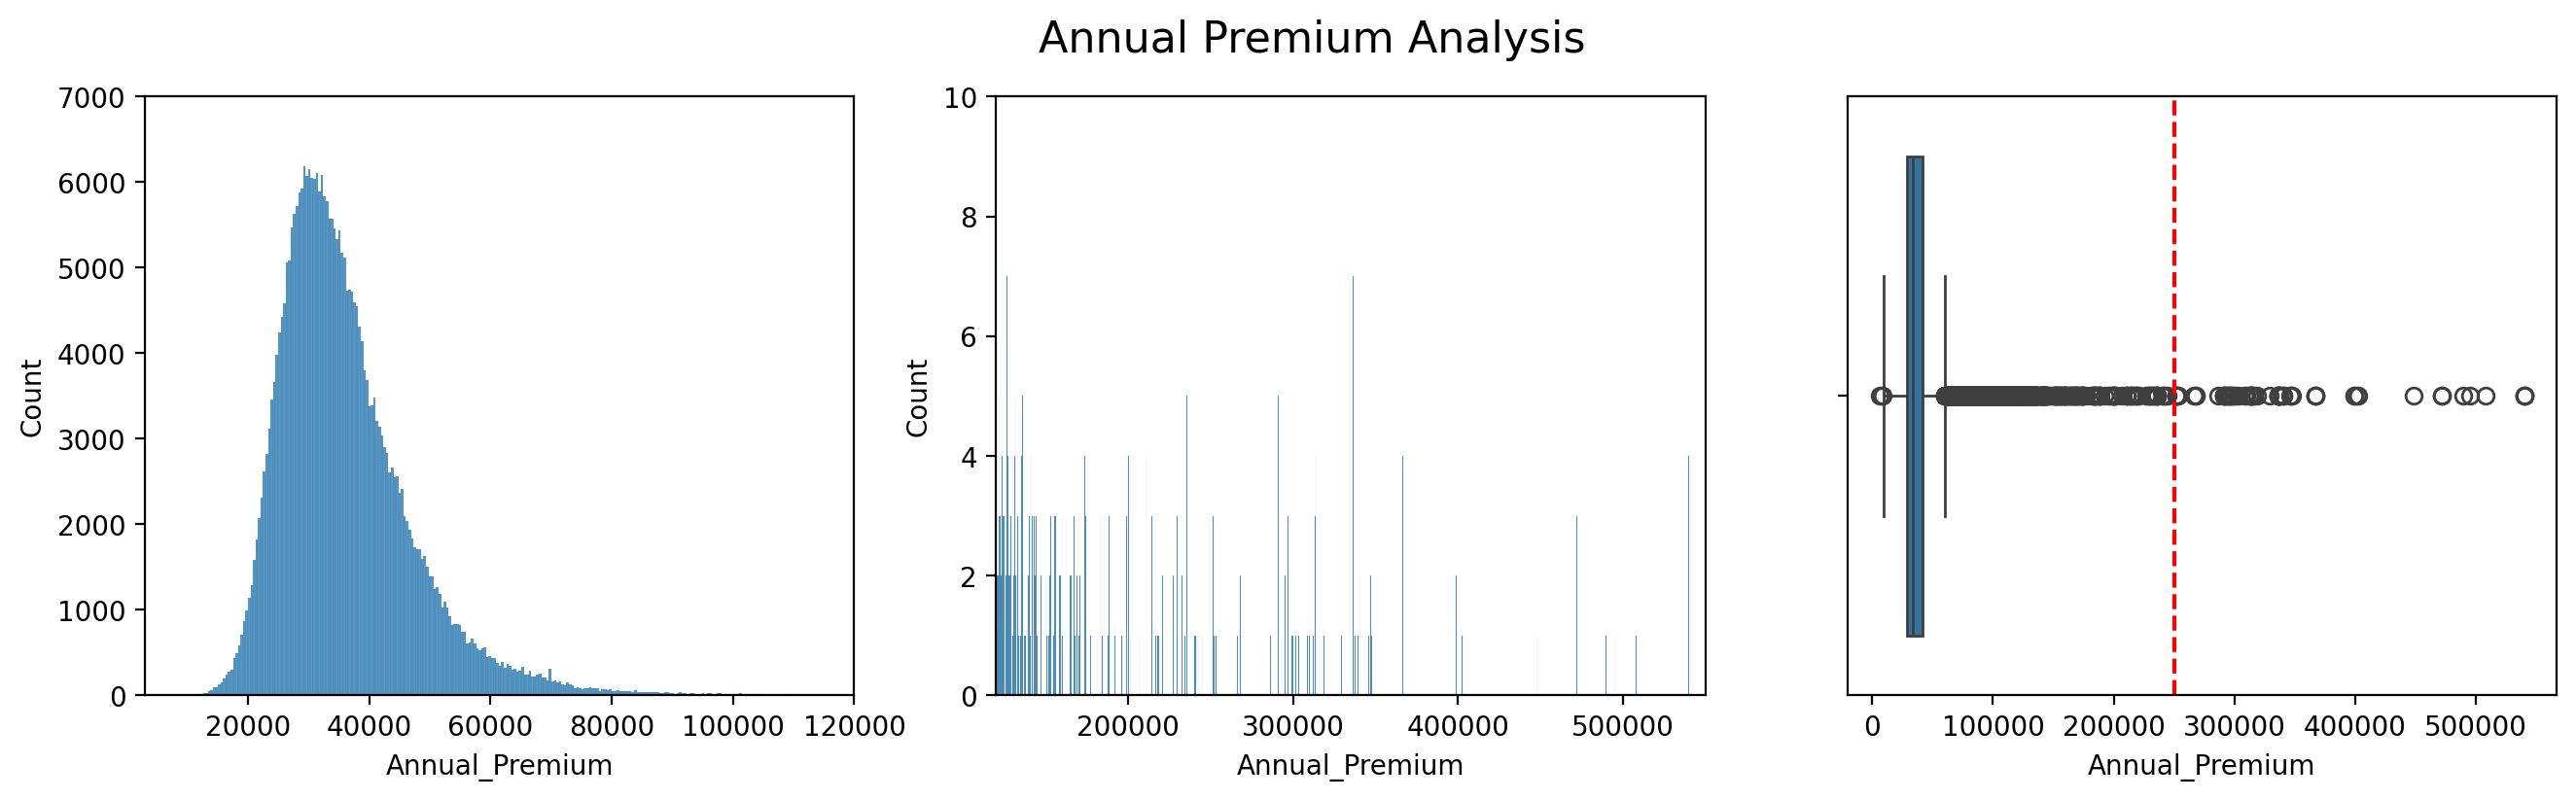

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
sns.histplot(data=df, x='Annual_Premium', ax=ax[0])
ax[0].set_xlim(3000, 120_000)
ax[0].set_ylim(0, 7000)

sns.histplot(data=df, x='Annual_Premium', ax=ax[1])
ax[1].set_xlim(120_000, 550_000)
ax[1].set_ylim(0, 10)

sns.boxplot(data=df2, x= 'Annual_Premium', ax=ax[2])
ax[2].axvline(250_000, color='r', linestyle='--')

fig.suptitle('Annual Premium Analysis', fontsize=16);

In [12]:
Q1 = df2['Annual_Premium'].quantile(0.25)
Q3 = df2['Annual_Premium'].quantile(0.75)
IQR = Q3 - Q1
print(f'whiskers as per 1.5 times iqr : {Q3-1.5*IQR}, {Q3+1.5*IQR}')

whiskers as per 1.5 times iqr : 22064.0, 60608.0


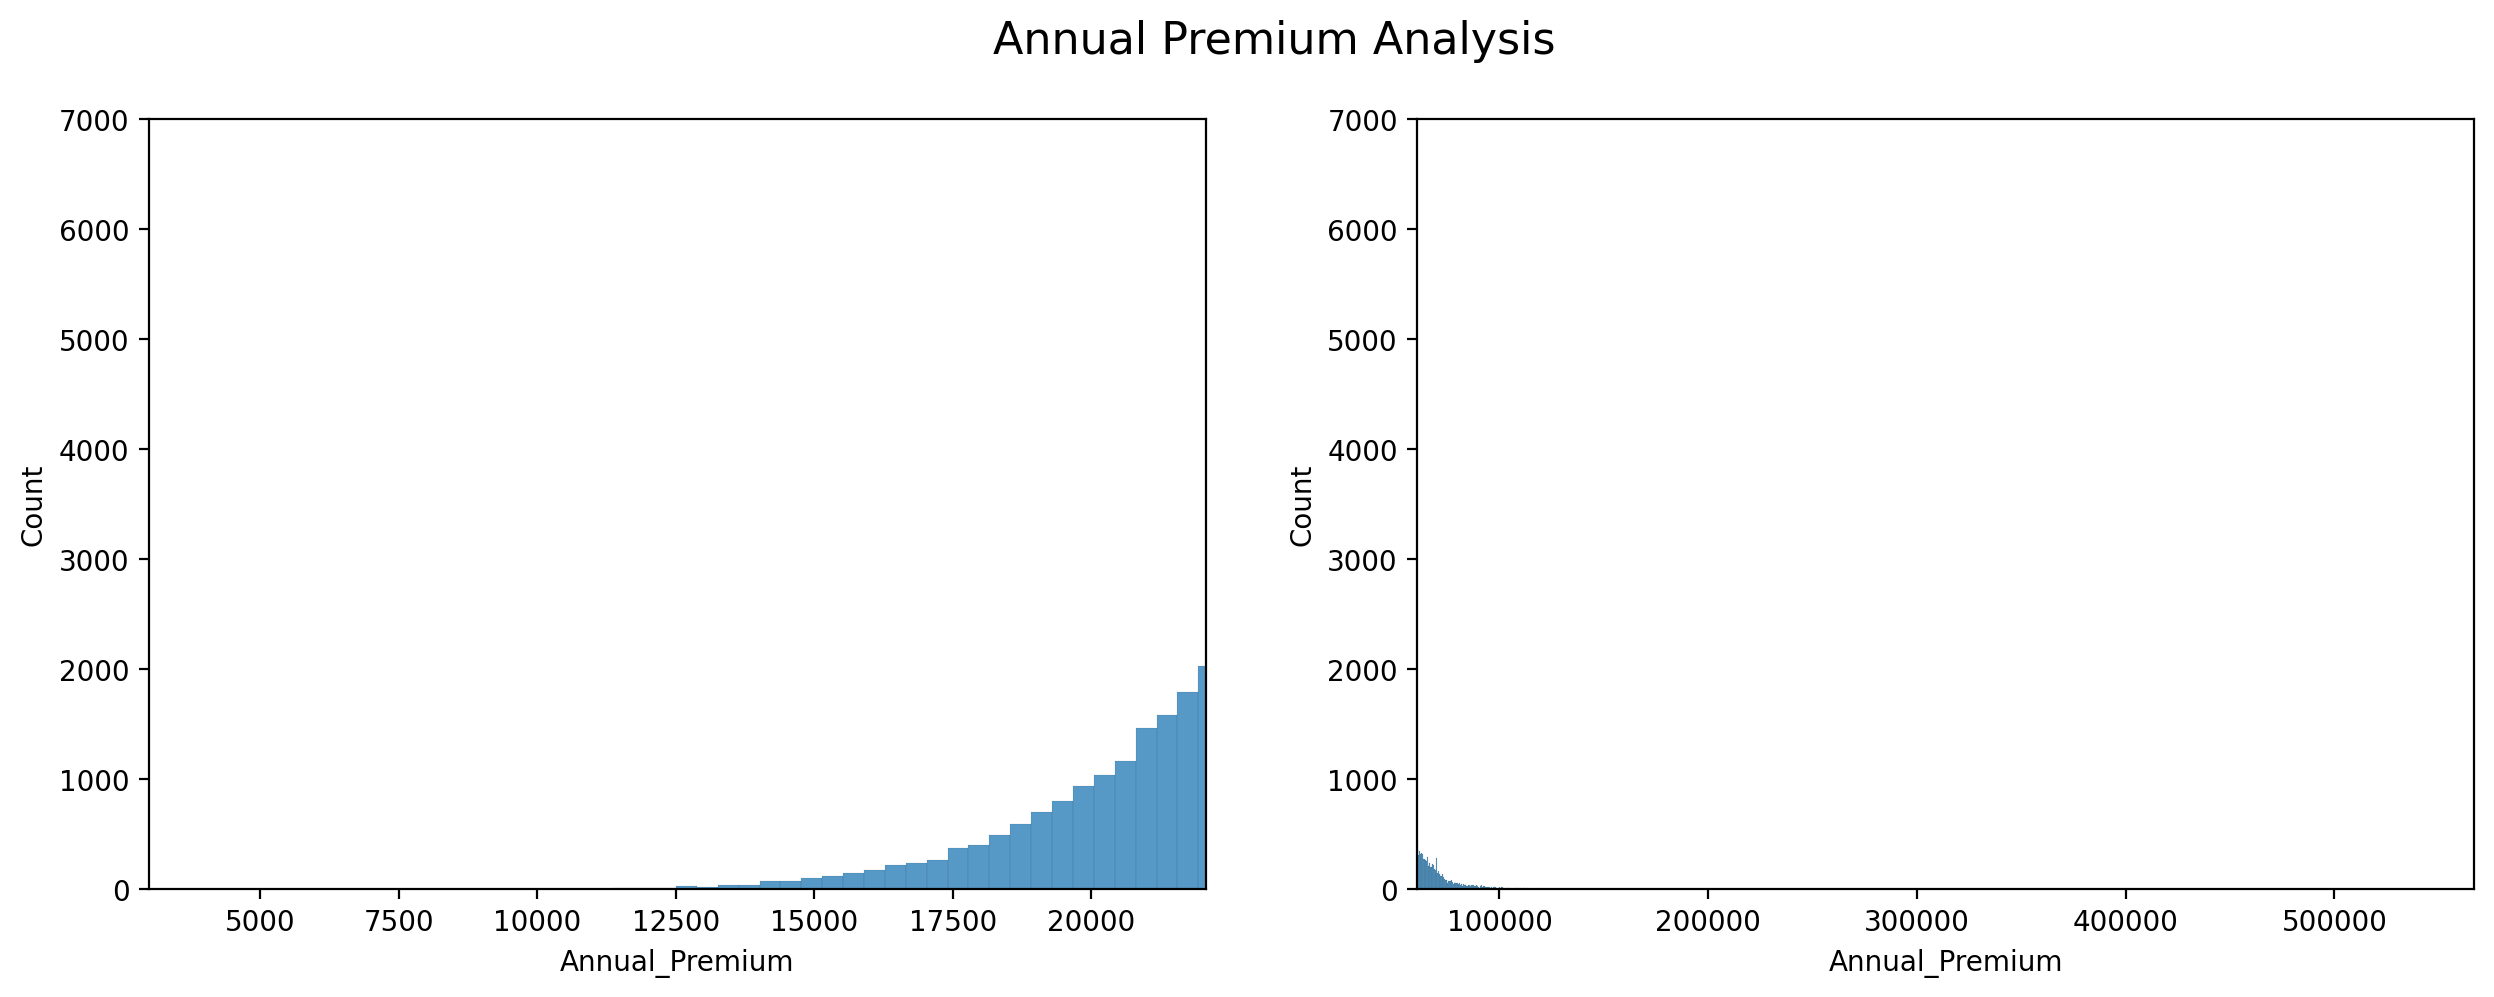

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(data=df2, x='Annual_Premium', ax=ax[0])
ax[0].set_xlim(3000, 22064)
ax[0].set_ylim(0, 7000)

sns.histplot(data=df2, x='Annual_Premium', ax=ax[1])
ax[1].set_xlim(60608, )
ax[1].set_ylim(0, 7000)

fig.suptitle('Annual Premium Analysis', fontsize=16);

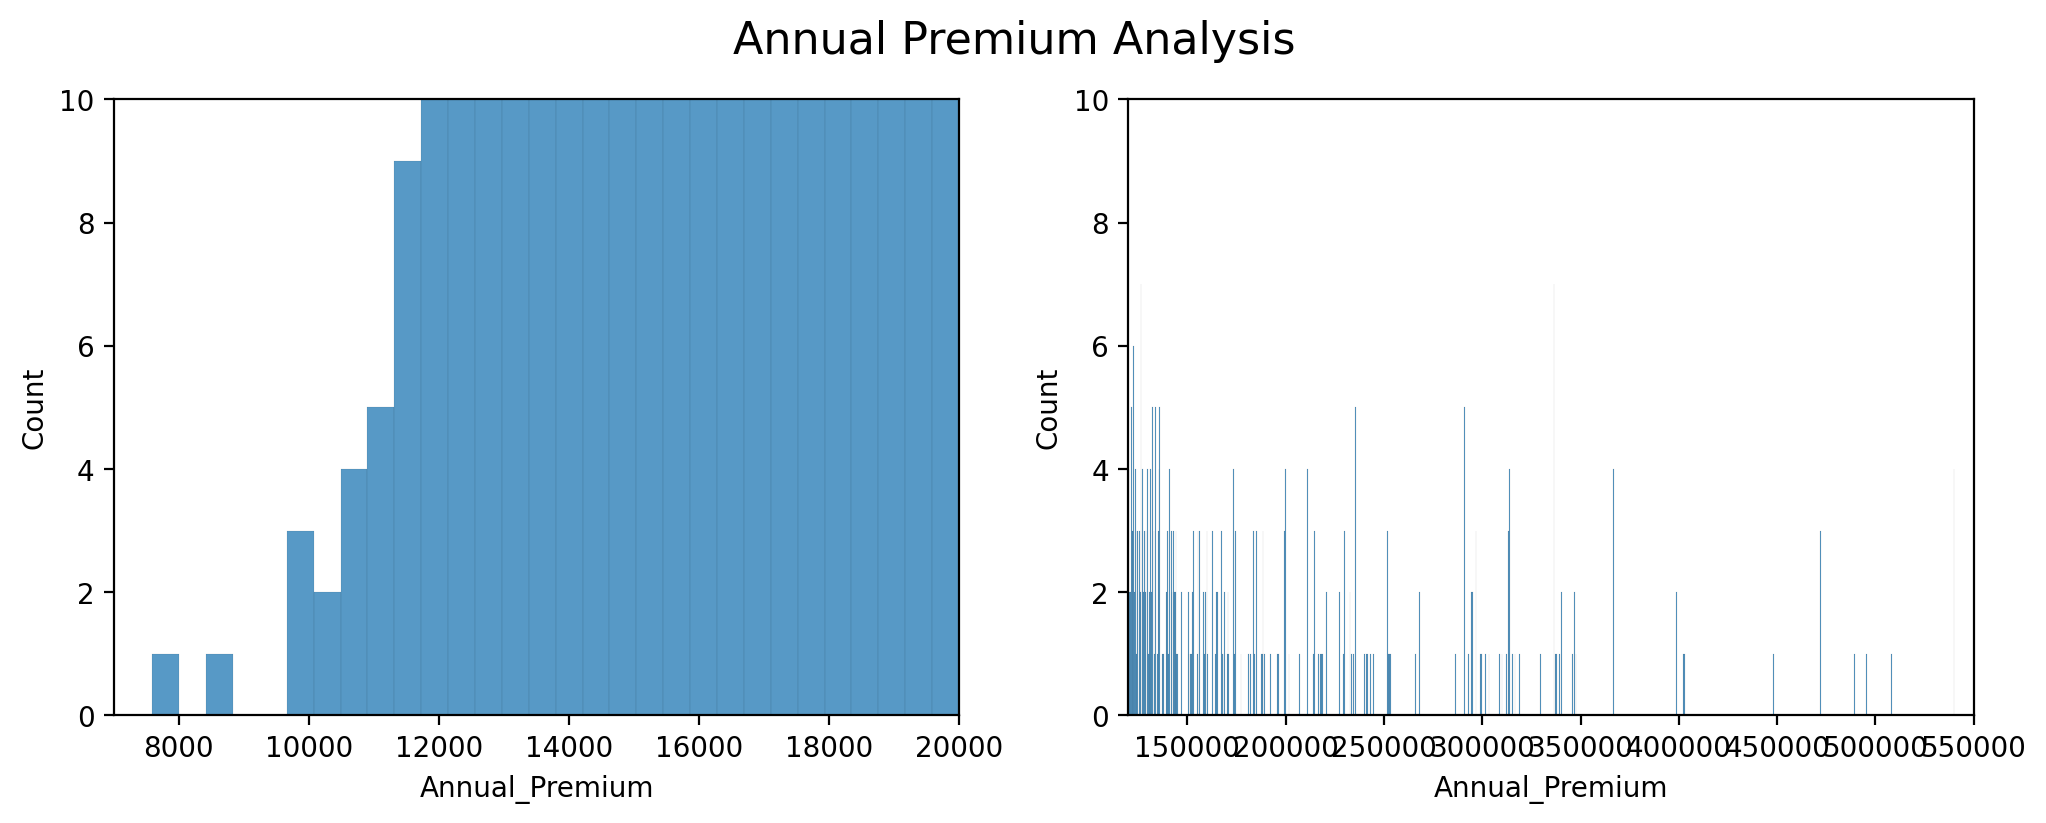

In [14]:
# extreme low count plots
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(data=df, x='Annual_Premium', ax=ax[0])
ax[0].set_xlim(7000, 20000)
ax[0].set_ylim(0, 10)

sns.histplot(data=df, x='Annual_Premium', ax=ax[1])
ax[1].set_xlim(120_000, 550_000)
ax[1].set_ylim(0, 10)

fig.suptitle('Annual Premium Analysis', fontsize=16);

1.5 times iqr eliminate large no. of record at lower whisker, and consist of gradual drop till 13_000. However, they're just low value customer and not anomilies. Similarily the upper extreme stretch uptil 500k or more.

There are 3 main approaches to handle this natural extreme:
1. [Model Selection] using robust algorithm which is not susceptible to the outliers/extreme values
2. [Data transformation] scaling variable data using logarithmic scales to reduce the impact of outliers
3. [Feature Engineering] create new feature that capture essence of outliers in variable data.publish_display_data

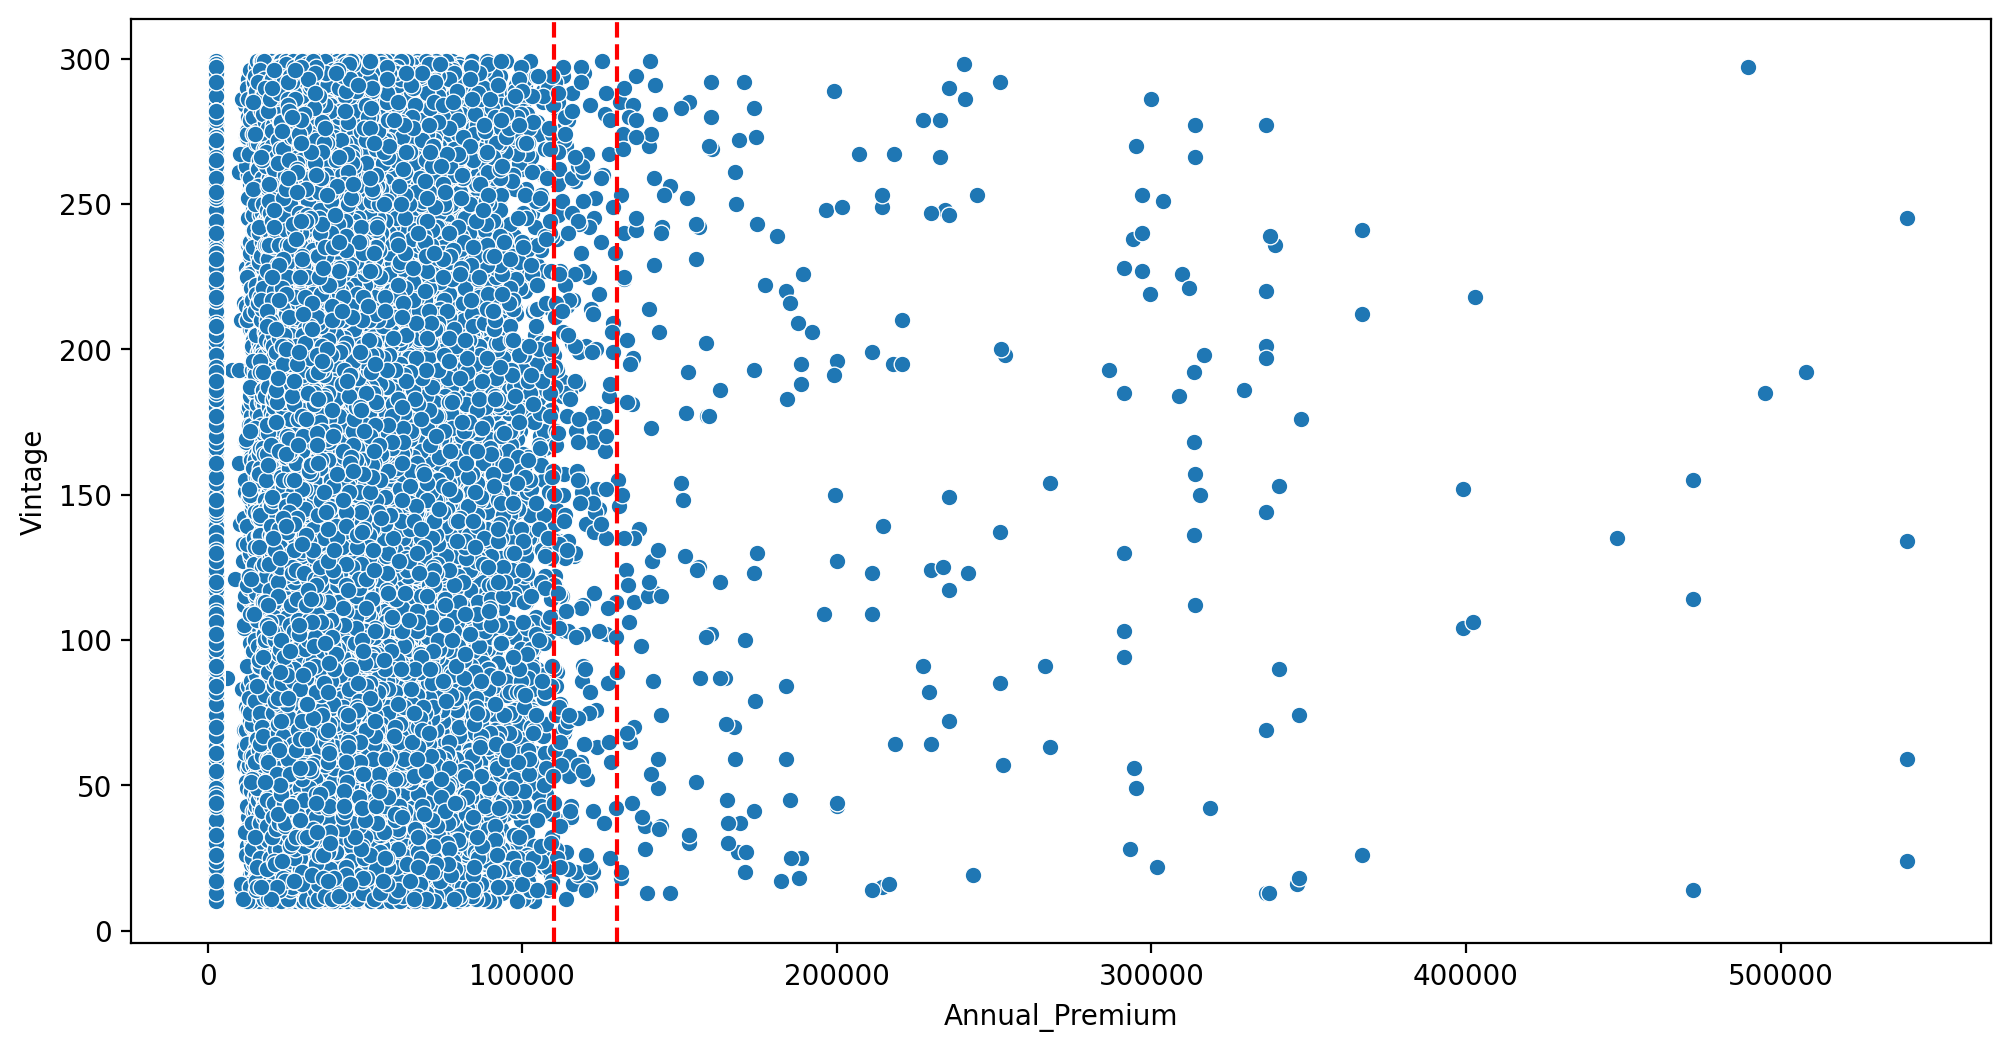

In [15]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x='Annual_Premium', y='Vintage')
plt.axvline(x=110_000, color='r', linestyle='--', label='Threshold: $120,000')
plt.axvline(x=130_000, color='r', linestyle='--', label='Threshold: $130,000');

In [16]:
# feature engineer original data-frame and adding new variable 'premium_level' at breakpoint of 2630, 17_000, 60_000, and 250_000.
df.loc[df['Annual_Premium'] == 2630, 'Premium_Level'] = 1
df.loc[df['Annual_Premium'] > 2_630, 'Premium_Level'] = 2
df.loc[df['Annual_Premium'] > 17_000, 'Premium_Level'] = 3
df.loc[df['Annual_Premium'] > 60_000, 'Premium_Level'] = 4
df.loc[df['Annual_Premium'] > 110_000, 'Premium_Level'] = 5
df['Premium_Level'].value_counts()

Premium_Level
3.0    302750
1.0     64877
4.0     11672
2.0      1323
5.0       487
Name: count, dtype: int64

In [17]:
df.describe()

id            Age  Driving_License    Region_Code  \
count  381109.000000  381109.000000    381109.000000  381109.000000   
mean   190555.000000      38.822584         0.997869      26.388807   
std    110016.836208      15.511611         0.046110      13.229888   
min         1.000000      20.000000         0.000000       0.000000   
25%     95278.000000      25.000000         1.000000      15.000000   
50%    190555.000000      36.000000         1.000000      28.000000   
75%    285832.000000      49.000000         1.000000      35.000000   
max    381109.000000      85.000000         1.000000      52.000000   

       Previously_Insured  Annual_Premium  Policy_Sales_Channel  \
count       381109.000000   381109.000000         381109.000000   
mean             0.458210    30564.389581            112.034295   
std              0.498251    17213.155057             54.203995   
min              0.000000     2630.000000              1.000000   
25%              0.000000    24405.000000             29.000000   
50%              0.000000    31669.000000            133.000000   
75%              1.000000    39400.000000            152.000000   
max              1.000000   540165.000000            163.000000   

             Vintage       Response  Premium_Level  
count  381109.000000  381109.000000  381109.000000  
mean      154.347397       0.122563       2.689246  
std        83.671304       0.327936       0.789666  
min        10.000000       0.000000       1.000000  
25%        82.000000       0.000000       3.000000  
50%       154.000000       0.000000       3.000000  
75%       227.000000       0.000000       3.000000  
max       299.000000       1.000000       5.000000

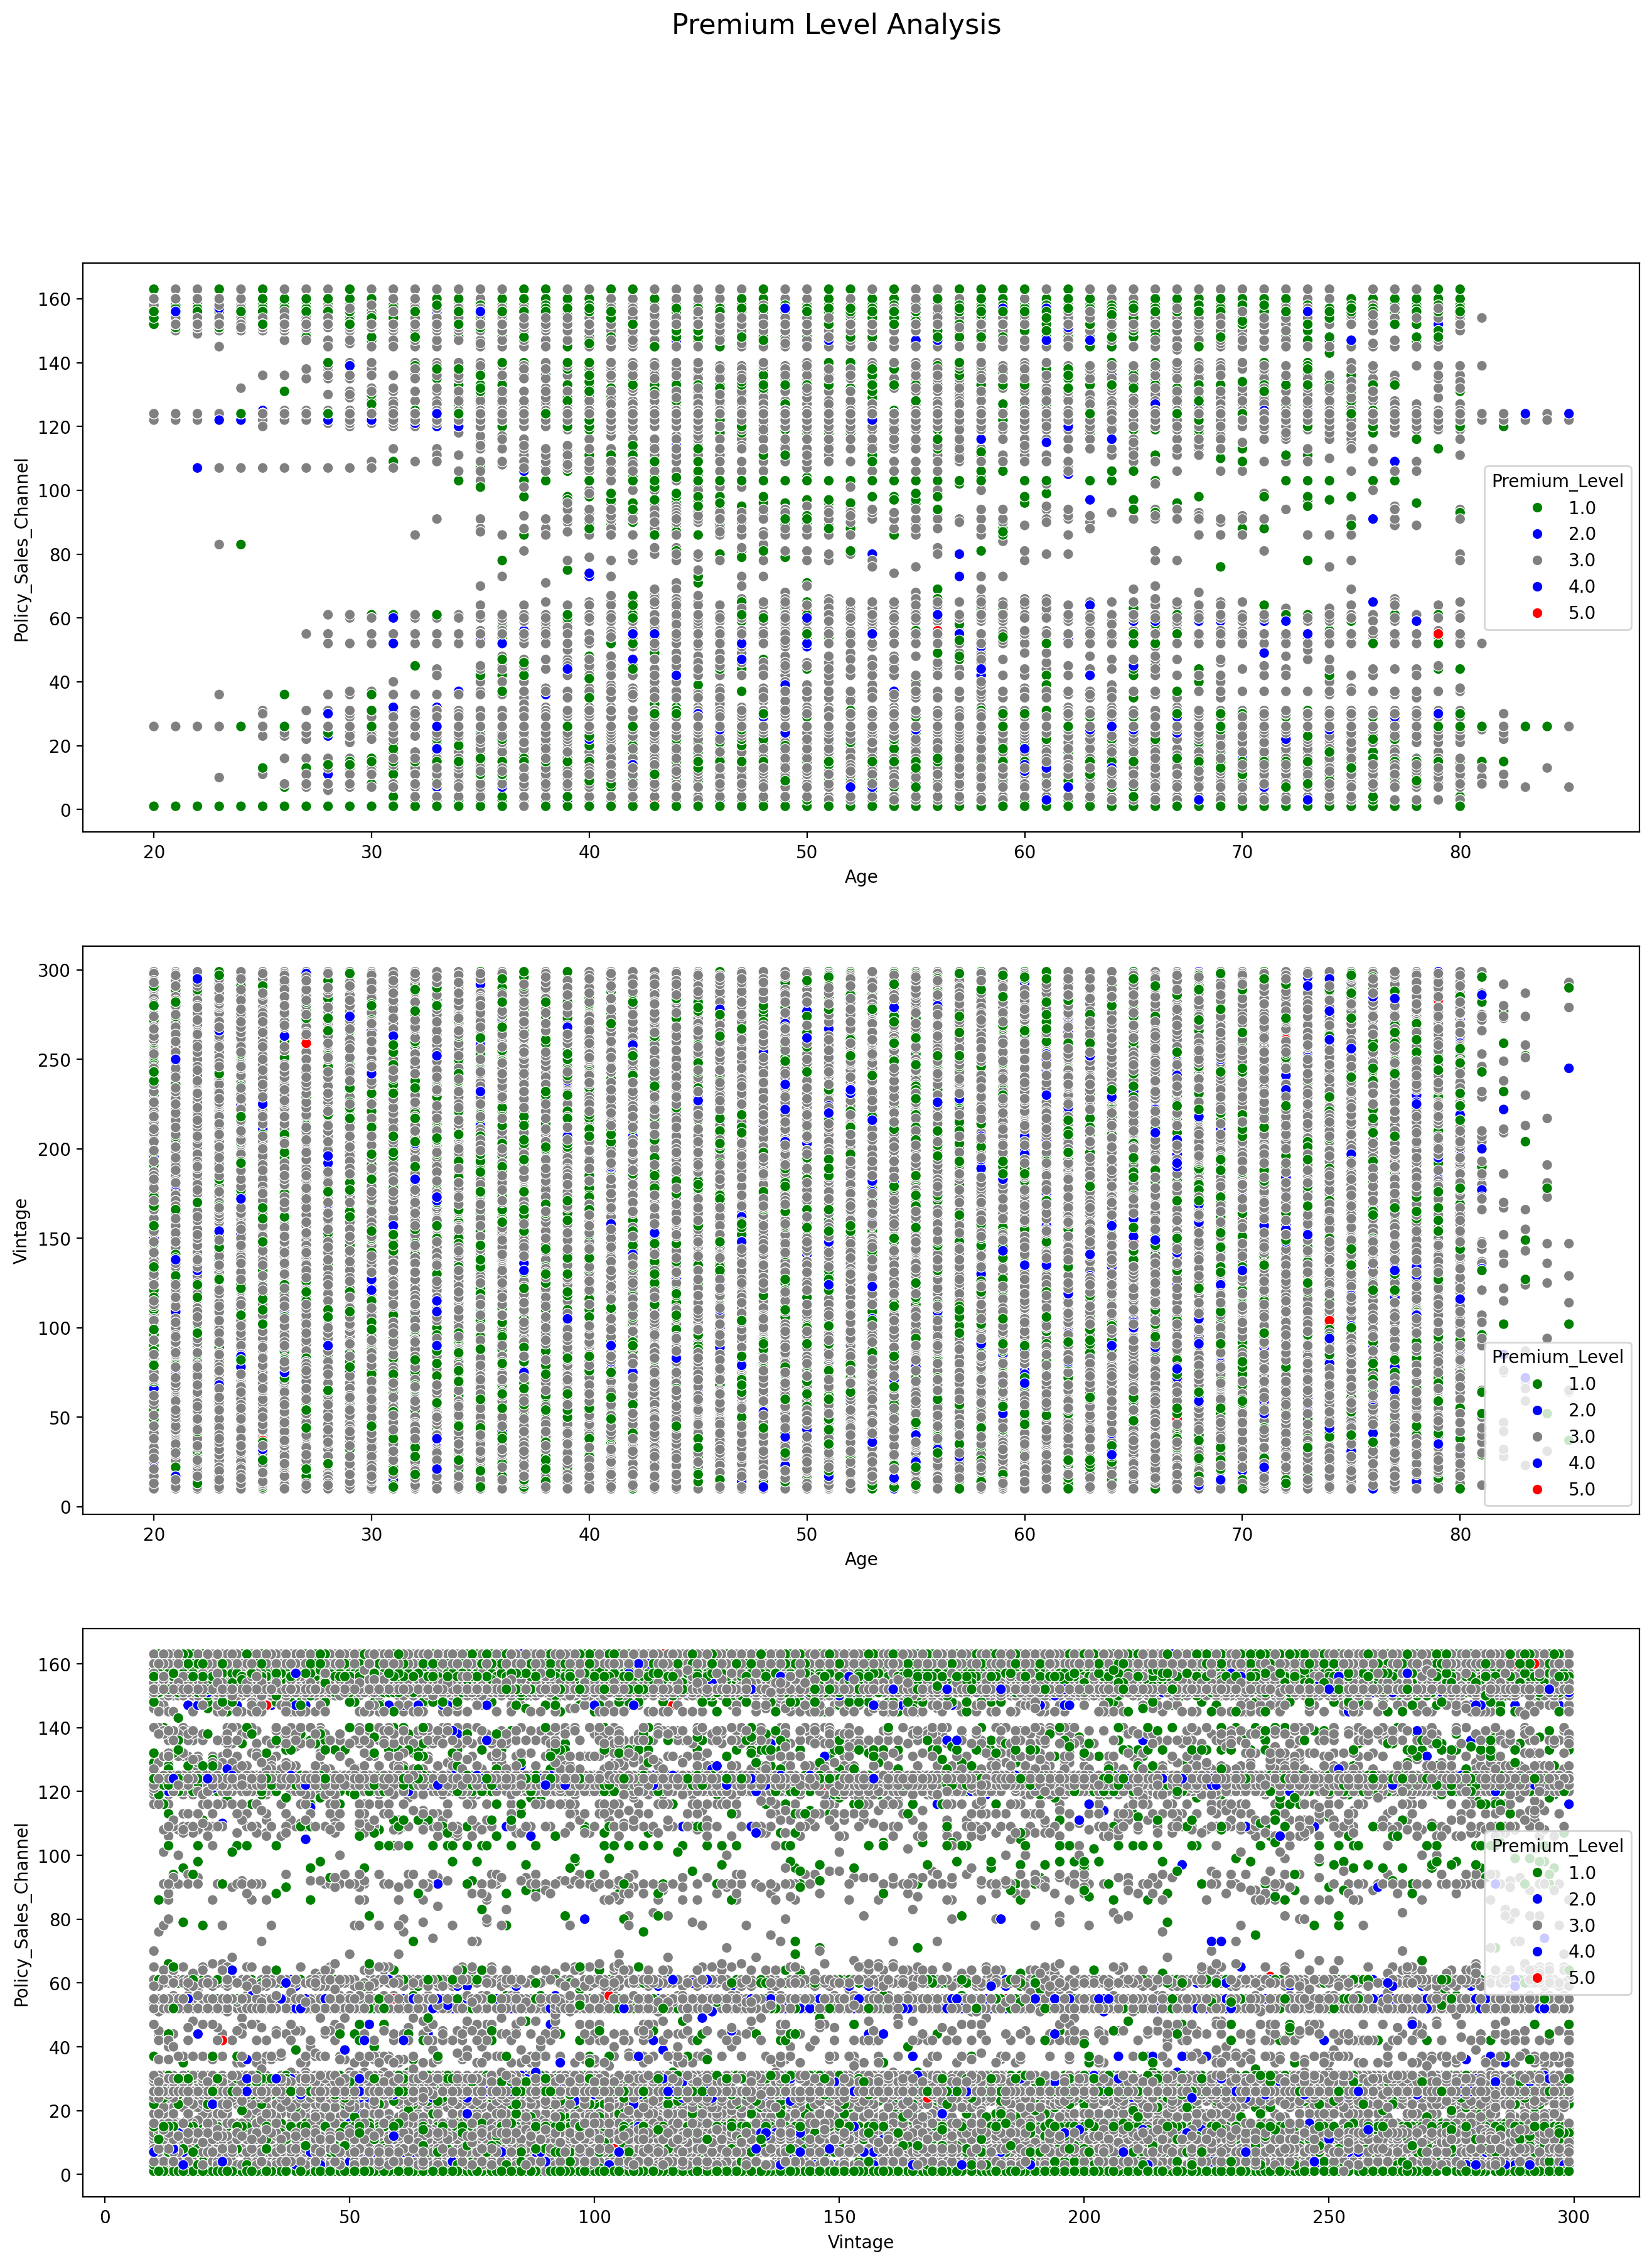

In [18]:
fig, ax = plt.subplots(3, 1, figsize=(16, 20))
custom_palette = {1: 'green', 2: 'blue', 3: 'grey', 4: 'blue', 5: 'red'}
sns.scatterplot(data=df, x='Age', y='Policy_Sales_Channel', hue='Premium_Level', palette=custom_palette, ax=ax[0])
sns.scatterplot(data=df, x='Age', y='Vintage', hue='Premium_Level', palette=custom_palette, ax=ax[1])
sns.scatterplot(data=df, x='Vintage', y='Policy_Sales_Channel', hue='Premium_Level', palette=custom_palette, ax=ax[2])
fig.get_tight_layout()
fig.suptitle('Premium Level Analysis', fontsize=16);

There appears to no pattern in premium-level

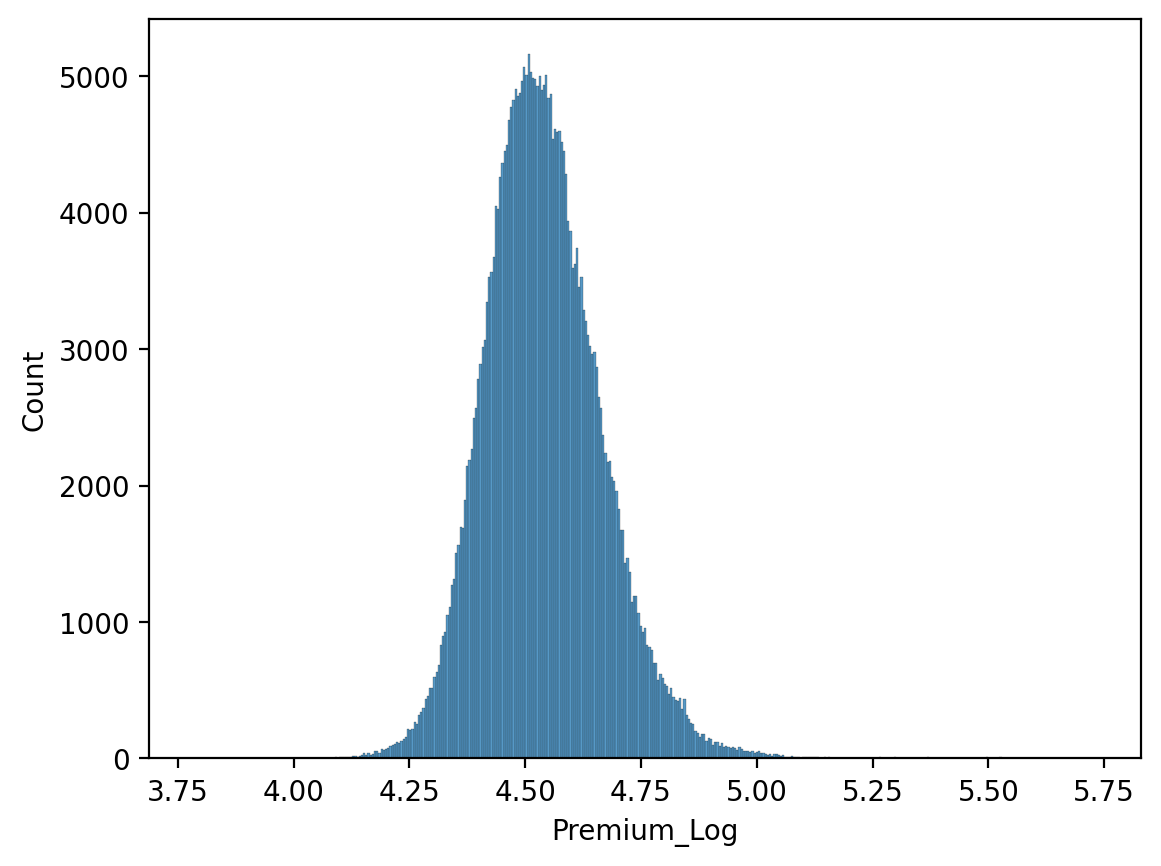

In [19]:
df['Premium_Log'] = np.log10(df['Annual_Premium'])
sns.histplot(data=df.query('Premium_Level > 1'), x='Premium_Log');

## Analysing Vehicle Insurance Response

In [20]:
df.columns

Index(['id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response', 'Premium_Level',
       'Premium_Log'],
      dtype='object')

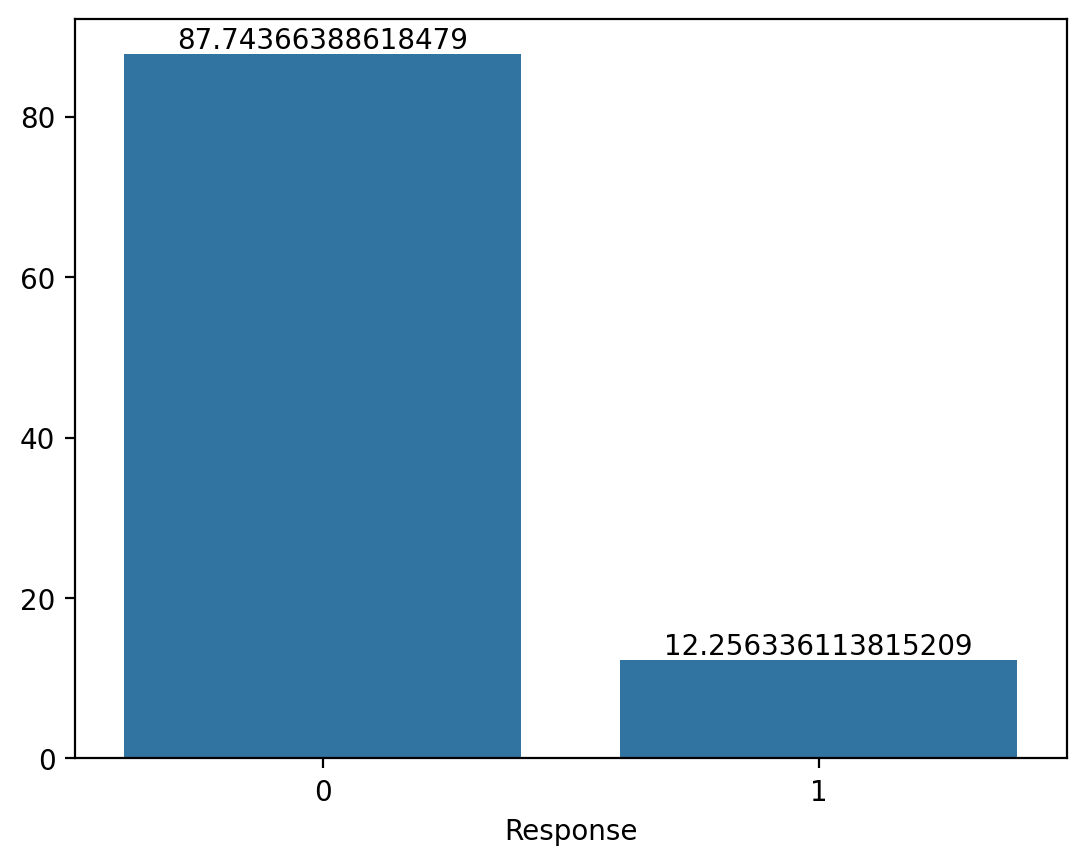

In [21]:
response_ratio = 100 * df['Response'].value_counts(normalize=True)
ax = sns.barplot(x=response_ratio.index, y=response_ratio.values)
ax.bar_label(ax.containers[0], labels=response_ratio.values, fontsize=10);

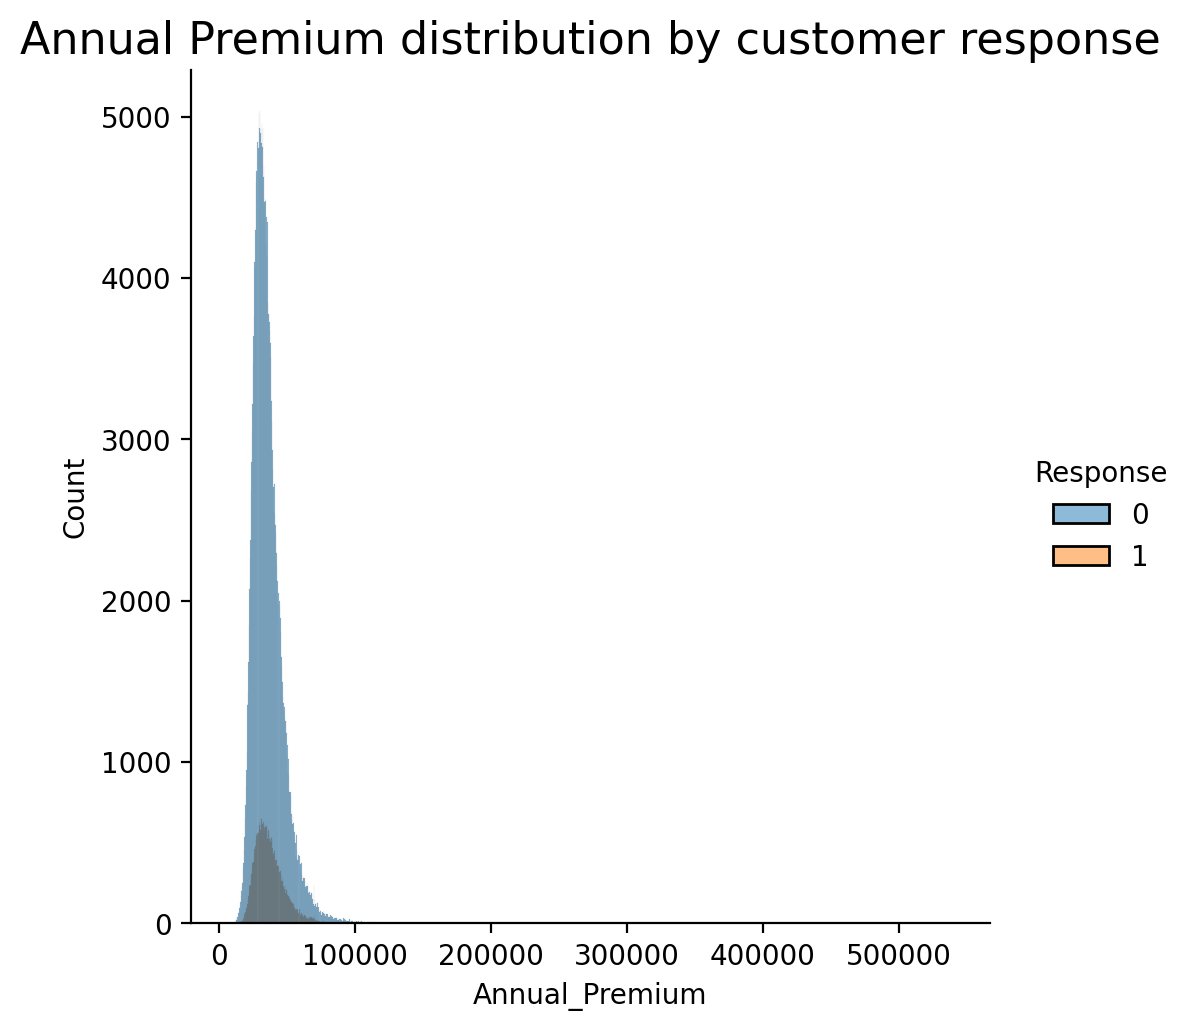

In [25]:
sns.displot(data=df.query('Premium_Level > 1'), x='Annual_Premium', hue='Response')
plt.title('Annual Premium distribution by customer response', fontsize = 16);

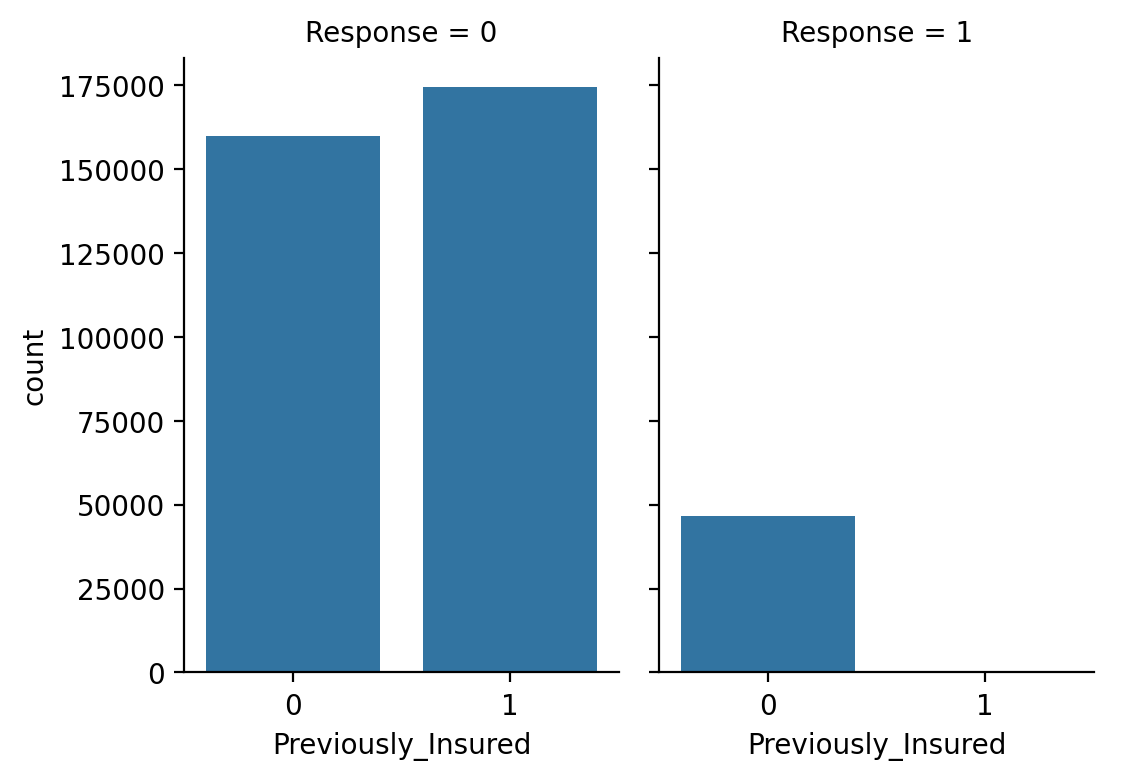

In [30]:
count_df = df.groupby(['Previously_Insured', 'Response']).size().reset_index(name='count')
sns.catplot(x="Previously_Insured", y="count", col="Response", data=count_df, kind="bar", height=4, aspect=.7);

* If customer is previously insured, it is very unlikely to get positive response (customer interest) for the insurance.

## Feature Engineering

In [20]:
df.describe(include=object)

Gender Vehicle_Age Vehicle_Damage
count   381109      381109         381109
unique       2           3              2
top       Male    1-2 Year            Yes
freq    206089      200316         192413

In [21]:
df.select_dtypes(include=object).value_counts()

Gender  Vehicle_Age  Vehicle_Damage
Male    1-2 Year     Yes               79533
Female  < 1 Year     No                66047
Male    < 1 Year     No                50543
Female  1-2 Year     Yes               48692
Male    1-2 Year     No                42791
Female  1-2 Year     No                29300
        < 1 Year     Yes               25274
Male    < 1 Year     Yes               22922
        > 2 Years    Yes               10293
Female  > 2 Years    Yes                5699
                     No                    8
Male    > 2 Years    No                    7
dtype: int64

In [22]:
df['Gender']            = df['Gender'].replace({'Female': 0, 'Male': 1})
df['Vehicle_Damage']    = df['Vehicle_Damage'].replace({'Yes': 1, 'No': 0})
df['Vehicle_Age']       = df['Vehicle_Age'].replace({'< 1 Year': 1, '1-2 Year': 2, '> 2 Years': 3})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  int64  
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  int64  
 4   Region_Code           381109 non-null  float64
 5   Previously_Insured    381109 non-null  int64  
 6   Vehicle_Age           381109 non-null  int64  
 7   Vehicle_Damage        381109 non-null  int64  
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  float64
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  int64  
 12  Premium_Level         381109 non-null  float64
 13  Premium_Log           381109 non-null  float64
dtypes: float64(5), int64(9)
memory usage: 40.7 MB


In [23]:
df.describe()

id         Gender            Age  Driving_License  \
count  381109.000000  381109.000000  381109.000000    381109.000000   
mean   190555.000000       0.540761      38.822584         0.997869   
std    110016.836208       0.498336      15.511611         0.046110   
min         1.000000       0.000000      20.000000         0.000000   
25%     95278.000000       0.000000      25.000000         1.000000   
50%    190555.000000       1.000000      36.000000         1.000000   
75%    285832.000000       1.000000      49.000000         1.000000   
max    381109.000000       1.000000      85.000000         1.000000   

         Region_Code  Previously_Insured    Vehicle_Age  Vehicle_Damage  \
count  381109.000000       381109.000000  381109.000000   381109.000000   
mean       26.388807            0.458210       1.609616        0.504877   
std        13.229888            0.498251       0.567439        0.499977   
min         0.000000            0.000000       1.000000        0.000000   
25%        15.000000            0.000000       1.000000        0.000000   
50%        28.000000            0.000000       2.000000        1.000000   
75%        35.000000            1.000000       2.000000        1.000000   
max        52.000000            1.000000       3.000000        1.000000   

       Annual_Premium  Policy_Sales_Channel        Vintage       Response  \
count   381109.000000         381109.000000  381109.000000  381109.000000   
mean     30564.389581            112.034295     154.347397       0.122563   
std      17213.155057             54.203995      83.671304       0.327936   
min       2630.000000              1.000000      10.000000       0.000000   
25%      24405.000000             29.000000      82.000000       0.000000   
50%      31669.000000            133.000000     154.000000       0.000000   
75%      39400.000000            152.000000     227.000000       0.000000   
max     540165.000000            163.000000     299.000000       1.000000   

       Premium_Level    Premium_Log  
count  381109.000000  381109.000000  
mean        2.689246       4.349327  
std         0.789666       0.436501  
min         1.000000       3.419956  
25%         3.000000       4.387479  
50%         3.000000       4.500634  
75%         3.000000       4.595496  
max         5.000000       5.732526

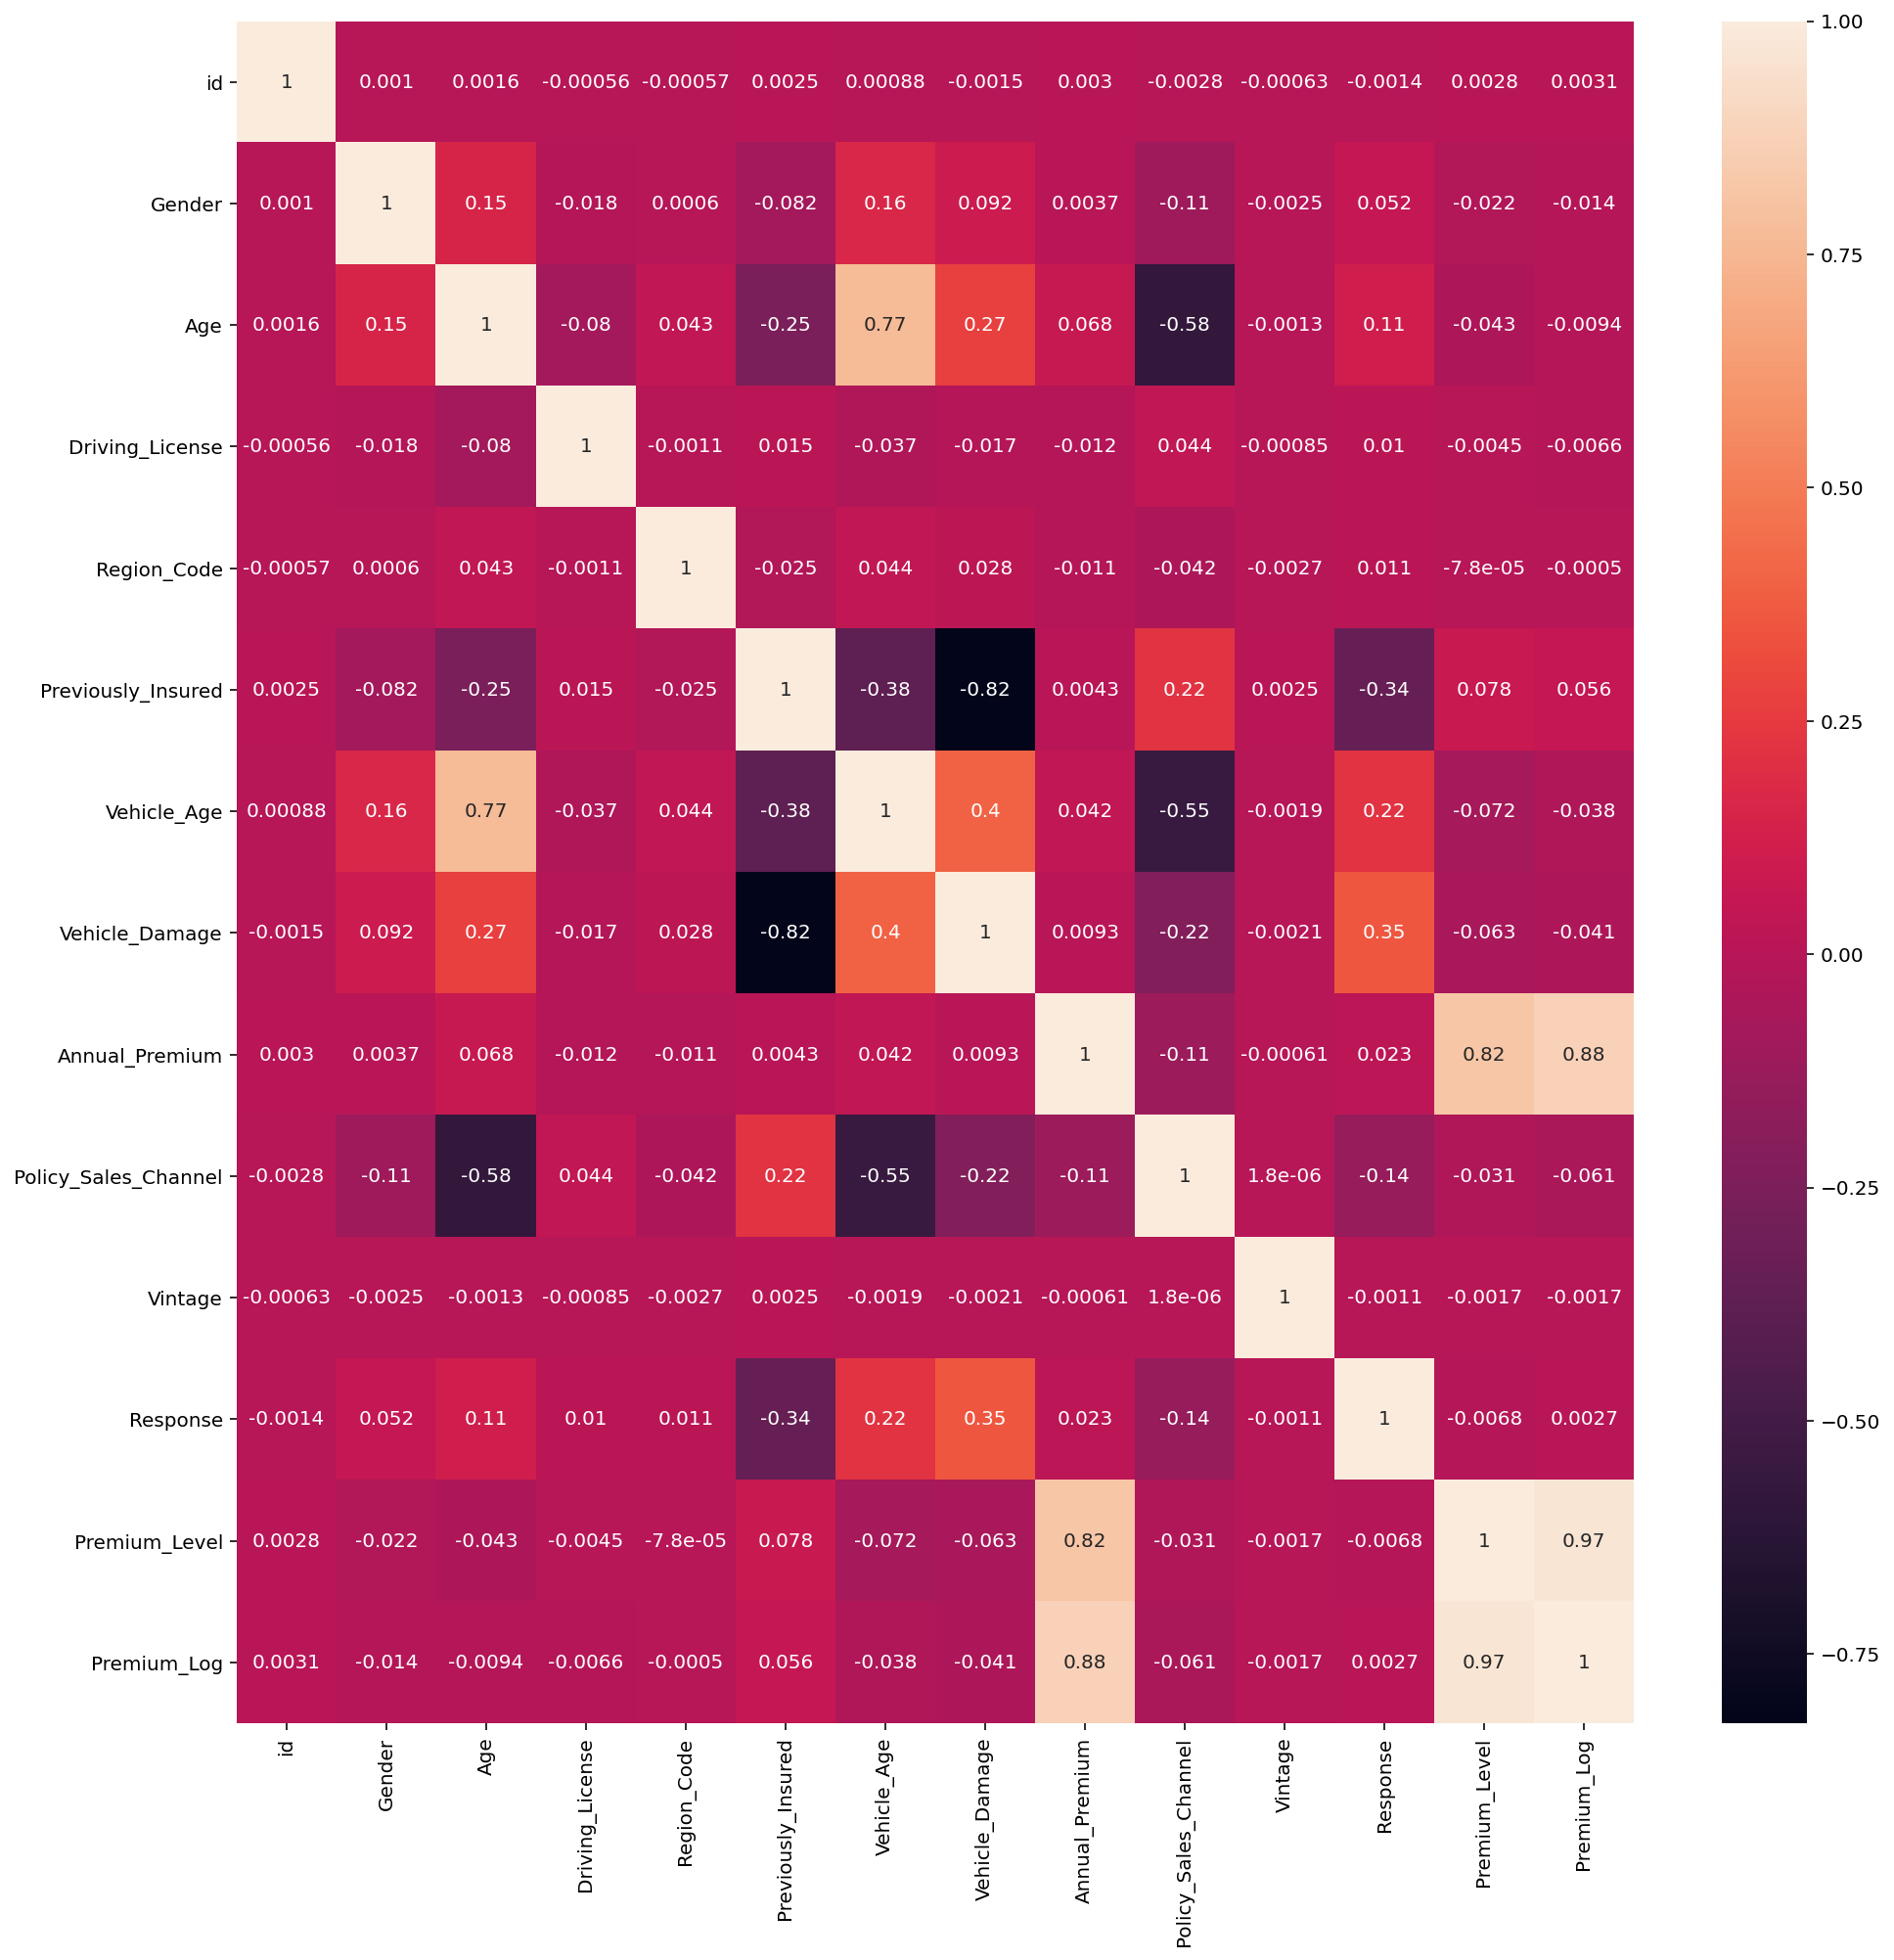

In [24]:
corrMatrix = df.corr()
plt.figure(figsize=(16, 16))
sns.heatmap(corrMatrix, annot = True)
plt.show()

Given low linear colleration, between most features against "premium" feature, suggesting weak linear relationship for predicting "premium" features and linear regression won't be a good fit for this data.

In [26]:
# saving data frame for modeling
df.to_csv('../artifacts/data.csv', index=False)

Refer to modeling.ipynb for different models that were experimented.

### attempt to improve performance with polynomial featuring

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

# Create polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

# Split the data into training and testing sets
Xtrain_poly, Xtest_poly, ytrain, ytest = train_test_split(X_poly, y, test_size=0.3, stratify=y, random_state=42)

In [ ]:
Xtrain_poly.shape

In [ ]:
from sklearn.model_selection import GridSearchCV

# parameter options to fit model
param_grid = {
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10]
}

# Initialize the grid search
grid_search = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(Xtrain_poly, ytrain)
best_dt = grid_search.best_estimator_

# Performance of best estimator on the test set
ypred = best_dt.predict(Xtest_poly)
score = best_dt.score(Xtest_poly, ytest)
print(f'DecisionTreeClassifier accuracy: {score}')

In [ ]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Try Random Forest
rf = RandomForestClassifier()
rf.fit(Xtrain_poly, ytrain)
rf_score = rf.score(Xtest_poly, ytest)
print(f'RandomForestClassifier accuracy: {rf_score}')

# Try Gradient Boosting
gb = GradientBoostingClassifier()
gb.fit(Xtrain_poly, ytrain)
gb_score = gb.score(Xtest_poly, ytest)
print(f'GradientBoostingClassifier accuracy: {gb_score}')

In [ ]:
pd.DataFrame(rf.predict(X_poly)).value_counts()

In [ ]:
pd.DataFrame(best_dt.predict(X_poly)).value_counts()